Shape: (3000, 5)

Sample Data:
    Unnamed: 0   book_id                  book_name    genre  \
0           0   3248537          Drowned Wednesday  Fantasy   
1           1  27796919              The Lost Hero  Fantasy   
2           2   3910776  The Eyes of the Overworld  Fantasy   
3           3   5969644            Magic's Promise  Fantasy   
4           4   3173445             Taran Wanderer  Fantasy   

                                             summary  
0   Drowned Wednesday is the first Trustee among ...  
1   As the book opens, Jason awakens on a school ...  
2   Cugel is easily persuaded by the merchant Fia...  
3   The book opens with Herald-Mage Vanyel return...  
4   Taran and Gurgi have returned to Caer Dallben...  

Missing values:
 Unnamed: 0    0
book_id       0
book_name     0
genre         0
summary       0
dtype: int64

Genre distribution:
 genre
Fantasy             500
Science Fiction     500
Crime Fiction       500
Historical novel    500
Horror              500


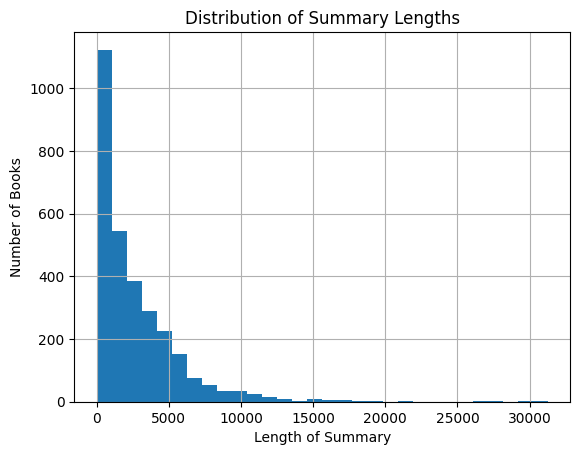

In [2]:
import pandas as pd

# Load the cleaned dataset
books = pd.read_csv('BooksDataSet.csv', on_bad_lines='skip', quoting=1, encoding='utf-8')

# Check the shape
print("Shape:", books.shape)

# Preview the data
print("\nSample Data:\n", books.head())

# Check for missing values
print("\nMissing values:\n", books.isnull().sum())

# Check class distribution
print("\nGenre distribution:\n", books['genre'].value_counts())

# Check summary lengths
books['summary_length'] = books['summary'].astype(str).apply(len)
print("\nSummary length stats:\n", books['summary_length'].describe())

# Optional: Histogram of summary lengths
import matplotlib.pyplot as plt
books['summary_length'].hist(bins=30)
plt.title("Distribution of Summary Lengths")
plt.xlabel("Length of Summary")
plt.ylabel("Number of Books")
plt.show()



In [3]:
# !pip install -U adapter-transformers
# !pip install datasets


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 59.3 MB/s eta 0:00:00
  Created wheel for adapter-transformers: filename=adapter_transformers-4.0.0-py3-none-any.whl size=2630 sha256=094e0b19dadf7a69b8b9de024a6dfc0786100a868f461ed49a6e0874a2df2bad
  Stored in directory: /root/.cache/pip/wheels/a3/6e/b6/e4aa8aa04c274f709d2dc14499cd973de79e2c3e63bfc766ae
Successfully built adapter-transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.2
    Uninstalling transformers-4.52.2:
      Successfully uninstalled transformers-4.52.2


In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer


In [4]:
books = pd.read_csv("BooksDataSet.csv")
books = books[['book_id', 'book_name', 'genre', 'summary']]


In [5]:
books = books[books['summary'].str.len() > 30].reset_index(drop=True)


In [6]:
label_encoder = LabelEncoder()
books['label'] = label_encoder.fit_transform(books['genre'])


In [7]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [20]:
class BookSummaryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),  # [seq_len]
            'attention_mask': encoding['attention_mask'].squeeze(),  # [seq_len]
            'label': torch.tensor(label, dtype=torch.long)
        }


In [15]:
dataset = BookSummaryDataset(
    texts=books['summary'].tolist(),
    labels=books['label'].tolist(),
    tokenizer=tokenizer
)

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [10]:
from torch.optim import AdamW



In [11]:
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification
from torch.optim import AdamW  # ✅ Fixed import

# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels=6  # 6 genres
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
from sklearn.model_selection import train_test_split

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    books['summary'].tolist(),
    books['label'].tolist(),
    test_size=0.2,
    stratify=books['label'],
    random_state=42
)


In [24]:
# Use the same BookSummaryDataset class as before
train_dataset = BookSummaryDataset(train_texts, train_labels, tokenizer)
val_dataset = BookSummaryDataset(val_texts, val_labels, tokenizer)


In [25]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [ ]:
import torch
from tqdm import tqdm
import torch.nn.functional as F

def train_model(model, train_loader, val_loader, optimizer, device, num_epochs=3):
    model.to(device)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()

        total_train_loss = 0
        correct_train = 0
        total_train = 0

        train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}]")
        for batch in train_loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            correct_train += (predictions == labels).sum().item()
            total_train += labels.size(0)

            train_accuracy = correct_train / total_train
            train_loop.set_postfix(loss=loss.item(), accuracy=train_accuracy)

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

        # ------------------- VALIDATION STEP -------------------
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                total_val_loss += loss.item()
                predictions = torch.argmax(logits, dim=1)
                correct_val += (predictions == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}")


In [19]:
train_model(model, train_loader, val_loader, optimizer, device, num_epochs=3)



Epoch 1/3


Epoch [1]: 100%|██████████| 150/150 [03:47<00:00,  1.51s/it, accuracy=0.773, loss=0.161]


Epoch 1 Training Loss: 0.6840, Accuracy: 0.7733
Epoch 1 Validation Loss: 0.5971, Accuracy: 0.8047

Epoch 2/3


Epoch [2]: 100%|██████████| 150/150 [03:45<00:00,  1.51s/it, accuracy=0.869, loss=0.283]


Epoch 2 Training Loss: 0.4313, Accuracy: 0.8693
Epoch 2 Validation Loss: 0.6800, Accuracy: 0.7763

Epoch 3/3


Epoch [3]: 100%|██████████| 150/150 [03:45<00:00,  1.51s/it, accuracy=0.93, loss=0.754]


Epoch 3 Training Loss: 0.2429, Accuracy: 0.9303
Epoch 3 Validation Loss: 0.6150, Accuracy: 0.7980


In [26]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
import os

def train_model_with_early_stopping(model, train_loader, val_loader, optimizer, device, num_epochs=10, patience=2, save_path='best_model.pt'):
    model.to(device)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()

        total_train_loss = 0
        correct_train = 0
        total_train = 0

        train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}]")
        for batch in train_loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            correct_train += (predictions == labels).sum().item()
            total_train += labels.size(0)

            train_accuracy = correct_train / total_train
            train_loop.set_postfix(loss=loss.item(), accuracy=train_accuracy)

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

        # ------------------- VALIDATION STEP -------------------
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                total_val_loss += loss.item()
                predictions = torch.argmax(logits, dim=1)
                correct_val += (predictions == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

        # ------------------- EARLY STOPPING CHECK -------------------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
            print(f"✅ Validation loss improved. Model saved to: {save_path}")
        else:
            epochs_no_improve += 1
            print(f"⏳ No improvement in validation loss for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print("⛔ Early stopping triggered.")
            break

    print("Training complete.")


In [27]:
train_model_with_early_stopping(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    patience=2,
    save_path='best_bert_model.pt'
)



Epoch 1/10


Epoch [1]: 100%|██████████| 150/150 [04:04<00:00,  1.63s/it, accuracy=0.545, loss=0.822]


Epoch 1 Training Loss: 1.2464, Accuracy: 0.5453
Epoch 1 Validation Loss: 0.8837, Accuracy: 0.7028
✅ Validation loss improved. Model saved to: best_bert_model.pt

Epoch 2/10


Epoch [2]: 100%|██████████| 150/150 [04:05<00:00,  1.64s/it, accuracy=0.767, loss=0.865]


Epoch 2 Training Loss: 0.6919, Accuracy: 0.7674
Epoch 2 Validation Loss: 0.7317, Accuracy: 0.7362
✅ Validation loss improved. Model saved to: best_bert_model.pt

Epoch 3/10


Epoch [3]: 100%|██████████| 150/150 [04:05<00:00,  1.64s/it, accuracy=0.868, loss=0.314]


Epoch 3 Training Loss: 0.4208, Accuracy: 0.8685
Epoch 3 Validation Loss: 0.7938, Accuracy: 0.7496
⏳ No improvement in validation loss for 1 epoch(s).

Epoch 4/10


Epoch [4]: 100%|██████████| 150/150 [04:05<00:00,  1.63s/it, accuracy=0.932, loss=0.289]


Epoch 4 Training Loss: 0.2233, Accuracy: 0.9319
Epoch 4 Validation Loss: 0.8981, Accuracy: 0.7112
⏳ No improvement in validation loss for 2 epoch(s).
⛔ Early stopping triggered.
Training complete.


In [28]:
import pickle

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("LabelEncoder saved as label_encoder.pkl")


LabelEncoder saved as label_encoder.pkl


In [31]:
from google.colab import files

# Download model file
files.download("best_bert_model.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
from google.colab import files
import zipfile
import os

# Optional: Verify the file exists
assert os.path.exists("best_bert_model.pt"), "Model file not found."

# Step 1: Zip the model file
with zipfile.ZipFile("best_bert_model.zip", "w") as zipf:
    zipf.write("best_bert_model.pt")

# Step 2: Download the zipped model
files.download("best_bert_model.zip")


# # Step 3: Download the label encoder
# files.download("label_encoder.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>